# Paleo-Temperature Inversion

Goal: characterize historical air temperatures based on the current ice temperature profile.

<img src="PaleoTemp.png" alt="drawing" width="600"/>

In [1]:
import pymuqModeling as mm
import pymuqApproximation as ma

import numpy as np
import matplotlib.pyplot as plt
import h5py

## Load the model and prior distribuion

In [2]:
modFile = h5py.File('PaleoTempModel.h5','r')
priorFile = h5py.File('PaleoTempPrior.h5','r')

ts = modFile['/Model/ts']
zs = modFile['/Model/zs']

A = np.array(modFile['/Model/Matrix'])
b = np.array(modFile['/Model/Offset'])

priorMu = np.array(priorFile['/PriorDist/Mean'])
priorCov = np.array(priorFile['/PriorDist/Covariance'])


## Construct a MUQ Gaussian prior

In [3]:
priorDist = mm.Gaussian(priorMu, priorCov)

## Compute the Posterior

#### Load synthetic "observations"

In [4]:
data = modFile['/Data/Vals']

#### Define the observation noise

In [5]:
obsVar = 1e-8*np.ones(data.shape[0])

#### Do the math to compute the posterior

In [6]:
postDist = priorDist.Condition(A, data-b, obsVar)

stdDev = np.diag(np.sqrt(postDist.GetCovariance()))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


## Plot the Results

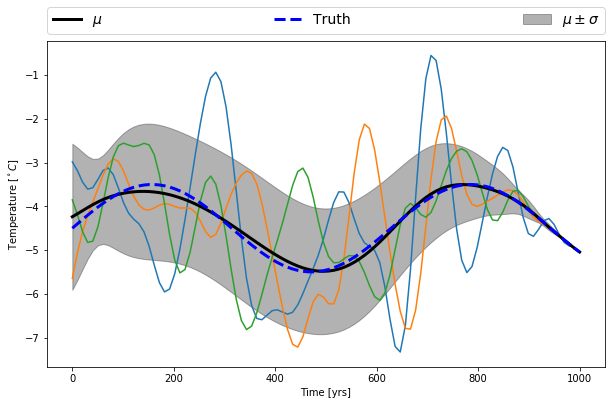

In [7]:
plt.figure(figsize=(10,6))

# Standard deviations
plt.fill_between(ts, postDist.GetMean() + stdDev, postDist.GetMean() - stdDev,
                    color='k',alpha=0.3, label='$\mu\pm\sigma$')
# A few samples
for i in range(3):
    samp = postDist.Sample()
    plt.plot(ts, samp)
    

plt.plot(ts, postDist.GetMean(),'-k',linewidth=3,label='$\mu$')
plt.plot(ts, modFile['/Data/TrueAirTemp'], '--b', linewidth=3, label='Truth')

# Make it pretty
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=3, mode="expand", borderaxespad=0., fontsize=14)

plt.xlabel('Time [yrs]')
plt.ylabel('Temperature [$^\circ C$]')

plt.show()

## Compute the Posterior Predictive

In [8]:
predDist = mm.Gaussian(A@postDist.GetMean() + b, A@postDist.GetCovariance()@A.T)

### Plot the posterior predictive

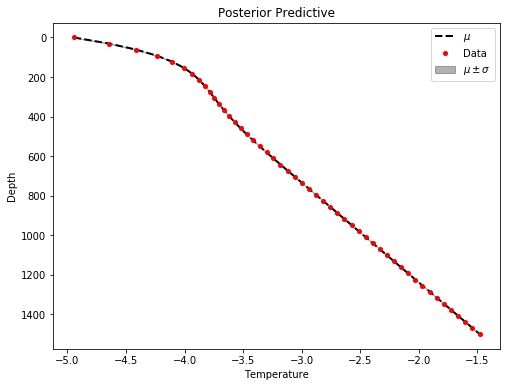

In [9]:
plt.figure(figsize=(8,6))

predStdDev = np.sqrt(np.diag(predDist.GetCovariance()))

# Std deviations
plt.fill_betweenx(zs, predDist.GetMean()-predStdDev, predDist.GetMean()+predStdDev,
                  color='k', alpha=0.3, label='$\mu\pm\sigma$')

# Mean
plt.plot(predDist.GetMean(),zs, '--k', linewidth=2, label='$\mu$')

# True data
plt.plot(data,zs,'.r',markersize=8,label='Data')

plt.legend()
plt.title('Posterior Predictive')
plt.xlabel('Temperature')
plt.ylabel('Depth')
plt.gca().invert_yaxis()
plt.show()